In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as layers


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2023-psl-week-using-bloomberg-news/train.csv
/kaggle/input/2023-psl-week-using-bloomberg-news/test.csv


# Load dataset

In [2]:
filepath = "/kaggle/input/2023-psl-week-using-bloomberg-news/train.csv"

dataset = pd.read_csv(filepath)

In [3]:
dataset.head()

,Unnamed: 0,positive,negative,indecisive,score,y
0,2010-01-04,11.0,3.0,0.0,0.571429,0.043956
1,2010-01-05,6.0,6.0,3.0,0.000000,0.042511
2,2010-01-06,7.0,3.0,1.0,0.400000,0.041065
3,2010-01-07,9.0,5.0,0.0,0.285714,0.034180
4,2010-01-08,7.0,3.0,2.0,0.400000,0.049178


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2594 entries, 0 to 2593
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2594 non-null   object 
 1   positive    2594 non-null   float64
 2   negative    2594 non-null   float64
 3   indecisive  2594 non-null   float64
 4   score       2594 non-null   float64
 5   y           2594 non-null   float64
dtypes: float64(5), object(1)
memory usage: 121.7+ KB


In [5]:
dataset['sum'] = dataset['positive'] + dataset['negative'] + dataset['indecisive']
dataset.head(5)

,Unnamed: 0,positive,negative,indecisive,score,y,sum
0,2010-01-04,11.0,3.0,0.0,0.571429,0.043956,14.0
1,2010-01-05,6.0,6.0,3.0,0.000000,0.042511,15.0
2,2010-01-06,7.0,3.0,1.0,0.400000,0.041065,11.0
3,2010-01-07,9.0,5.0,0.0,0.285714,0.034180,14.0
4,2010-01-08,7.0,3.0,2.0,0.400000,0.049178,12.0


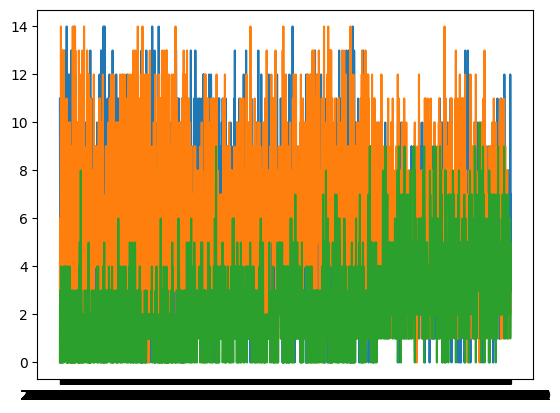

In [6]:
plt.plot(dataset['Unnamed: 0'], dataset['positive'])
plt.plot(dataset['Unnamed: 0'], dataset['negative'])
plt.plot(dataset['Unnamed: 0'], dataset['indecisive'])

# Prepare dataset

In [7]:
# dataset['Unnamed: 0'] = pd.to_datetime(dataset['Unnamed: 0'])
# dataset = dataset.set_index('Unnamed: 0')

In [8]:
# from sklearn.preprocessing import MinMaxScaler

# # Assuming 'Date' is a column in your dataset
# dataset['Timestamp'] = (dataset['Unnamed: 0'] - pd.Timestamp("Y")).dt.total_seconds()
# scaler = MinMaxScaler()
# dataset['Timestamp'] = scaler.fit_transform(dataset[['Timestamp']])

In [9]:
# try normalising each data point with the sum

In [10]:
dataset_sum = dataset.pop('sum')
y = dataset.pop('y')
x = dataset
dates = x.pop('Unnamed: 0')


In [11]:
x.head()

,positive,negative,indecisive,score
0,11.0,3.0,0.0,0.571429
1,6.0,6.0,3.0,0.000000
2,7.0,3.0,1.0,0.400000
3,9.0,5.0,0.0,0.285714
4,7.0,3.0,2.0,0.400000


In [12]:
y.head()

0    0.043956
1    0.042511
2    0.041065
3    0.034180
4    0.049178
Name: y, dtype: float64

# Define model

In [13]:
features = 1 # 1D data
input_shape = x.shape[1]

model = tf.keras.models.Sequential([
    layers.LSTM(units=64, input_shape=(input_shape, features), return_sequences=True),
    layers.LSTM(units=32),
    layers.Dense(units=1)
])

loss_function = tf.keras.losses.MeanAbsoluteError()
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001) # changed lr from 0.001
model.compile(loss = loss_function, optimizer=optimiser, metrics=['mae'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Test dataset

In [15]:
model.fit(x, y, epochs=50, batch_size=32)

Epoch 1/50
82/82 [==============================] - 5s 9ms/step - loss: 0.0544 - mae: 0.0544
Epoch 2/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0509 - mae: 0.0509
Epoch 3/50
82/82 [==============================] - 1s 9ms/step - loss: 0.0506 - mae: 0.0506
Epoch 4/50
82/82 [==============================] - 1s 9ms/step - loss: 0.0505 - mae: 0.0505
Epoch 5/50
82/82 [==============================] - 1s 9ms/step - loss: 0.0505 - mae: 0.0505
Epoch 6/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0502 - mae: 0.0502
Epoch 7/50
82/82 [==============================] - 1s 9ms/step - loss: 0.0507 - mae: 0.0507
Epoch 8/50
82/82 [==============================] - 1s 9ms/step - loss: 0.0504 - mae: 0.0504
Epoch 9/50
82/82 [==============================] - 1s 9ms/step - loss: 0.0508 - mae: 0.0508
Epoch 10/50
82/82 [==============================] - 1s 9ms/step - loss: 0.0501 - mae: 0.0501
Epoch 11/50
82/82 [==============================] - 1s 8ms/step - l

# Generate submission

In [16]:
test_dataset = pd.read_csv("/kaggle/input/2023-psl-week-using-bloomberg-news/test.csv")
dates = test_dataset.pop('Unnamed: 0')

In [17]:
test_dataset.head()

,positive,negative,indecisive,score
0,7.0,3.0,2.0,0.400000
1,1.0,11.0,2.0,-0.833333
2,7.0,5.0,2.0,0.166667
3,5.0,6.0,3.0,-0.090909
4,9.0,3.0,2.0,0.500000


In [18]:
predictions = model.predict(test_dataset)

30/30 [==============================] - 1s 3ms/step


In [19]:
submission = pd.DataFrame()
submission['date'] = dates
submission['y'] = predictions

In [20]:
submission.head()

,date,y
0,2020-01-02,0.044326
1,2020-01-03,0.042445
2,2020-01-06,0.046232
3,2020-01-07,0.048560
4,2020-01-08,0.042845


In [21]:
submission.describe()

,y
count,957.000000
mean,0.046883
std,0.003170
min,0.032226
25%,0.045428
50%,0.047346
75%,0.049272
max,0.052059


In [22]:
submission.to_csv('/kaggle/working/submission.csv',index=False,header=True)